In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from GalPop import *
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)

In [7]:
filtnames = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y',\
    'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484',\
    'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738',\
    'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_V',\
    'SC_rp', 'SC_ip', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2','GALEX_FUV', 'GALEX_NUV']

In [9]:
for i in [-1, 1, 3, -8, 8]:
    print(filtnames[i])

GALEX_NUV
CFHT_u
HSC_r
SC_V
UVISTA_J


---

First, let's load the galaxy populations

In [2]:
## Load Galaxy Populations ##
gp_folder = "LP_GalPops/"

tot_pops = [GalPop.loadFile(gp_folder + f) for f in sorted(os.listdir(gp_folder))]

Each individual galaxy population in this folder is the combination of ground-based spectroscopy, HST/Grism, and MCed COSMOS2020 photometry, after having been refit with LePhare. The following cuts were also applied:
- $2\leq z \leq 3$
- $149.6 \leq RA \leq 150.52$
- $1.74 \leq Dec \leq 2.73$
- minimum(IRAC_CH1, IRAC_CH2) $\leq 25.4$ (i.e. brighter than 25.4 in at least one channel)

The galaxy populations have a number of properties already:
- 'IDs' = COSMOS2020 ID (matched for spec/grism)
- 'ms' = Mass, refit in LePhare with the MCed redshift
- 'coords' = The (RA, Dec, z) for each galaxy
- 'obs_type' = Type of redshift
    - 0 = photo-z
    - 1 = spec-z
    - 2 = grism-z
- 'SFRs' = SFRs from LePhare
- 'n_sigmas' = The number of $n_\sigma$ over the mean overdensity in the redshift slice a galaxy is
- 'ODs' = the local-overdensity of the galaxy, $\log(1+\delta_{\rm gal})$
- 'mags' = A dictionary of magnitudes for each galaxy with the keys
    - NUV_ABS = NUV absolute mag from LePhare
    - u_ABS = U-band absolute mag from LePhare
    - r_ABS = r-band absolute mag from LePhare
    - V_ABS = V-band absolute mag from LePhare
    - J_ABS = J-band absolute mag from LePhare
    - IRAC = minimum(IRAC_CH1, IRAC_CH2), (apparent mag)
- 'subpops' = A dictionary of boolean-arrays of which galaxies are part of a subpopulation. The subpopulations are:
    - field1 = A field sample for $2.15 \leq z \leq 2.25$
    - field2 = A field sample for $2.8 \leq z \leq 2.9$
    - field = The combined field1 + field2 sample
    - h2.0 = Members of Hyperion with $n_\sigma \geq 2.0$
    - h2.5 = Members of Hyperion with $n_\sigma \geq 2.5$
    - h3.0 = Members of Hyperion with $n_\sigma \geq 3.0$
    - h3.5 = Members of Hyperion with $n_\sigma \geq 3.5$
    - h4.0 = Members of Hyperion with $n_\sigma \geq 4.0$
    - h4.5 = Members of Hyperion with $n_\sigma \geq 4.5$
    - h5.0 = Members of Hyperion with $n_\sigma \geq 5.0$

We can look at some for the first galaxy population (i.e. the first MC iteration)

In [3]:
t = tot_pops[0]

print("IDs:   ", t.IDs)
print('Masses:   ', t.ms)
print('obs_type:   ',   t.obs_type)
print('\nCoordinates',  t.coords)
print('\nn_sigma:   ', t.n_sigmas)
print('Overdensity:   ', t.ODs)
print('\nIRAC Magnitude:   ', t.mags['IRAC'])
print('\nIn the field?    ',t.subpops['field'])
print('\nIn Hyperion?    ',t.subpops['h2.0'])

IDs:    [ 335981  338768  339611 ... 1380578 1380611 1386724]
Masses:    [9.93631594 9.54163035 9.88392393 ... 9.71915215 9.60975622 9.2       ]
obs_type:    [1. 1. 1. ... 0. 0. 0.]

Coordinates [[150.14330276   1.74049276   2.74790001]
 [150.33236741   1.74368758   2.23889995]
 [149.99446659   1.74493941   2.13759995]
 ...
 [150.36981673   2.7251277    2.79695751]
 [150.36612021   2.72699653   2.41030089]
 [150.10558434   2.72960194   2.0738083 ]]

n_sigma:    [1.46597436 0.62761394 0.75271229 ... 1.81990616 1.45752198 0.2745392 ]
Overdensity:    [0.14444775 0.04607276 0.05932453 ... 0.18664209 0.11597366 0.01521547]

IRAC Magnitude:    [22.599533 23.09729  22.966301 ... 23.64639  23.458593 23.487726]

In the field?     [False  True False ... False False False]

In Hyperion?     [False False False ... False False False]


What if we want to make our own subpopulation(s)? Say, a field sample from $2\leq z \leq 2.05$, all galaxies in the total Galaxy populations with $2.5\leq n_\sigma $, and a sample of galaxies in Hyperion with $2.5\leq n_\sigma \leq 3.5 $? We do that with the "subPops" method:

In [4]:
# Load in the outputs of find_peaks
sig_cube = fits.open(r"/Hyperion_interpolated_cube_sigma.fits")
pk_path = "HyperionPeaks/"


for t in tot_pops:

    ## Make a new field sample for each galaxy population
    t.subPop("new_field", [-99, 4.0], 13. , [2.0, 2.05], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)


    ## Find all galaxies part of a structure with n_sig > 2.5
        # Make new sample
    t.subPop('new_sample', [2.5, np.inf], 13., [2.0, 3.0], pk_path, 'peaks_sig2.5.dat', sig_cube)


    ## Find all galaxies in Hyperion with 3.5 < n_sig < 4.5
        # Gets all of the galaxies in the cuts (may not be in Hyperion)
    t.subPop('new_Hyp', [2.5, 3.5], 13., [2.35, 2.7], pk_path, 'peaks_sig2.5.dat', sig_cube)

        # Make the subpopulation only include galaxies which are part of Hyperion, and meet the cut 2.5 <= n_sig <= 3.5
    t.subpops['new_Hyp'] = np.logical_and(t.subpops['new_Hyp'], t.subpops['h2.0'])


Great, we can check the new subpopulations out for the first MC iteration. Let's look at the Hyperion population

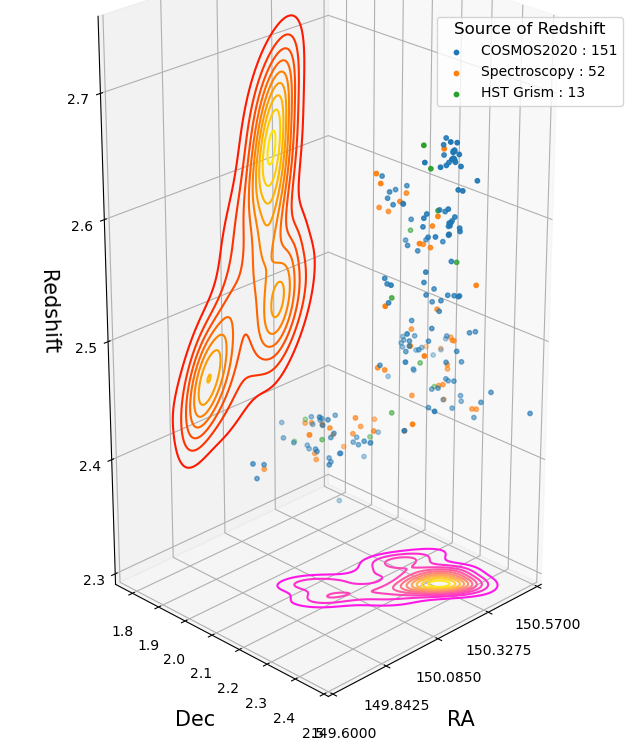

In [6]:
t = tot_pops[0]

ras = (149.6, 150.57)
decs = (1.75, 2.5)
zs = (2.3, 2.75)

t.popPlot2('new_Hyp',ras, decs, zs, 45, 25 )

If you make a lot of subpopulations and want to save the Galaxy pops for later use. This can be done. Note this can make the storage a little larger if you add a lot:

In [ ]:
save_folder = 'Examples/'

for i, t in enumerate(tot_pops):
    t.saveFile(save_folder + f'MC_{i}.npy')